In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:

data = pd.read_csv("df.csv")
data_corr = data.drop(columns=["Company", "Sector"])
kor_matice=data_corr.corr()

<Axes: >

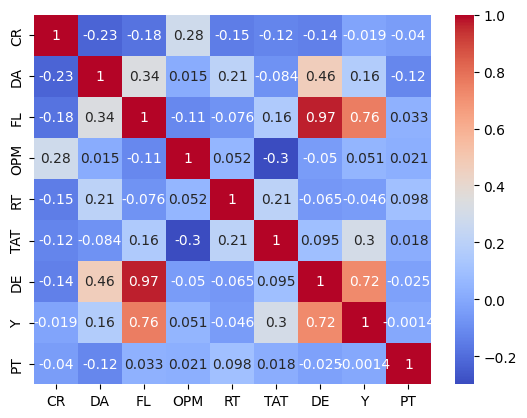

In [11]:
# vizualizace korelacni matice
sns.heatmap(kor_matice, annot=True, cmap='coolwarm')
#pokud berou v potaz pouze parametry v zadání ukazatel FL má největší vliv na Y

In [ ]:
# grafy parametru vs proměnná Y 
for column in data_corr.columns:
    if column != 'Y':
        plt.figure(figsize=(8, 4))
        plt.scatter(data_corr[column], data_corr['Y'])
        plt.title(f'{column} vs Y')
        plt.xlabel(column)
        plt.ylabel('Y')
        plt.show()
#FL má vysokou honotu korelace 0.76, ale graf vypadá jak rozsypaný čaj
# nevidím žádný zjevný trend pro transformaci 

In [ ]:
#OLS
formula = "Y ~  FL+TAT+OPM"
mod = smf.ols(formula=formula, data=data_corr)
res = mod.fit()
res.summary()
# vezmu v potaz pouze statisticky významné koeficienty dle p-testu adj.R2 je největší pro FL+TAT+OPM 

In [ ]:
data["MarksPredicted"] = res.predict(data)
data["rozdil"]=data["MarksPredicted"]-data["Y"]

row_high_rozdil=data["rozdil"].idxmax()
data.loc[row_high_rozdil]
#největší rozdíl je pro firmu SYXLy - 


In [ ]:
#Bonus 1 - RLM

#formula_rlm = "Y ~ FL+TAT+OPM+CR+DA+RT"
formula_rlm = "Y ~ FL+TAT+OPM+CR"
mod_rlm = smf.rlm(formula=formula_rlm, data=data_corr)
res_rlm = mod_rlm.fit()
res_rlm.summary()
#vyřadili jsme parametry s p<0.05

In [ ]:
data["MarksPredicted_rlm"] = res_rlm.predict(data)
data["rozdil_rlm"]=data["MarksPredicted_rlm"]-data["Y"]

row_high_rozdil_rlm=data["rozdil_rlm"].idxmax()
data.loc[row_high_rozdil_rlm]
#největší rozdíl RLM je stejně jako u OLS pro firmu SYXLy, ale rozdíl je u RLM menší 
# ??použila jsem jiné parametry pro model - je možné je srovnávat

In [78]:
#BONUS 2 - COOK
formula = "Y ~  FL+TAT+OPM"
influence = OLSInfluence(res)
data_corr['Cook Distance'] = influence.cooks_distance[0]
data_corr_cook = data_corr[data_corr['Cook Distance'] < 1]
# cook nevyřadil žádné řádky - výsledek tedy bude stejný jako v ukolu 1
mod_cook = smf.ols(formula=formula, data=data_corr_cook)
res_cook = mod_cook.fit()
res_cook.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     59.51
Date:                Wed, 15 Nov 2023   Prob (F-statistic):           7.99e-22
Time:                        22:25:53   Log-Likelihood:                -377.99
No. Observations:                 100   AIC:                             764.0
Df Residuals:                      96   BIC:                             774.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.4188      2.865     -3.637      0.000     -16.106      -4.732
FL             2.5281      0.208     12.149      0.000       2.115       2.941
TAT            8.5518      2.205      3.879      0.000       4.176      12.928
OPM           24.8478      7.542      3.295      0.001       9.878      39.818
==============================================================================
Omnibus:                       26.748   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.291
Skew:                           0.876   Prob(JB):                     2.71e-17
Kurtosis:                       6.904   Cond. No.                         50.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
data["MarksPredicted_cook"] = res_cook.predict(data)
data["rozdil_cook"]=data["MarksPredicted_cook"]-data["Y"]

row_high_rozdil_cook=data["rozdil_cook"].idxmax()
data.loc[row_high_rozdil_cook]
# vysledkz jsou stejne jako s prvni metodou (cook nevyřadil žádne hodnoty) - akcie firmy SYXLy má největší rozdíl mezi predikcí a cenou 

Company                      SYXLy
CR                            0.76
DA                            0.37
FL                           18.64
OPM                         0.0631
RT                           12.44
TAT                           0.41
DE                            6.93
Y                             6.97
PT                             3.4
Sector                 Industrials
MarksPredicted           41.779545
rozdil                   34.809545
MarksPredicted_rlm       40.250244
rozdil_rlm               33.280244
MarksPredicted_cook      41.779545
rozdil_cook              34.809545
Name: 79, dtype: object

In [106]:
#BONUS 3 - Sektor
sector_dummies = pd.get_dummies(data['Sector'])
sector_dummies.columns = [col.replace(' ', '') for col in sector_dummies.columns]
data_dumm = pd.merge(data, sector_dummies, left_index=True, right_index=True)
data_dumm=data_dumm.drop(columns=["Company", "Sector"])

In [107]:
data_dumm

,CR,DA,FL,OPM,RT,TAT,DE,Y,PT,MarksPredicted,...,BasicMaterials,CommunicationServices,Conglomerates,ConsumerCyclical,ConsumerDefensive,Energy,FinancialServices,Healthcare,Industrials,Technology
0,1.19,0.20,2.21,0.0770,6.66,0.40,0.43,1.95,5.93,0.502359,...,False,False,False,False,False,False,False,False,True,False
1,0.29,0.64,10.14,0.2037,20.04,0.36,6.52,7.26,43.48,23.356512,...,False,True,False,False,False,False,False,False,False,False
2,2.93,0.04,1.43,0.3055,6.55,0.72,0.06,7.78,18.38,6.944718,...,False,True,False,False,False,False,False,False,False,False
3,1.03,0.25,3.55,0.0708,146.43,1.80,0.88,6.17,5.15,15.708512,...,False,False,False,False,True,False,False,False,False,False
4,1.20,0.47,0.00,0.1677,30.92,0.93,0.00,0.00,17.06,1.701358,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.50,0.37,2.33,0.2557,4.92,0.41,0.85,5.18,6.83,5.331550,...,False,False,False,False,False,False,False,True,False,False
96,0.70,0.27,2.57,0.2363,16.11,0.64,0.69,7.40,2.70,7.423167,...,False,False,False,False,True,False,False,False,False,False
97,1.49,0.12,2.36,0.2576,8.64,0.51,0.28,5.99,7.59,6.309785,...,False,False,False,False,False,False,False,False,False,True
98,2.30,0.64,25.03,0.3758,7.48,0.31,16.08,41.57,10.54,64.848968,...,False,False,False,False,False,False,False,False,False,True


In [108]:

formula_dum = 'Y ~ '+' + '.join(sector_dummies)
mod_dum = smf.ols(formula=formula_dum , data=data_dumm)
res_dum = mod_dum.fit()
res_dum.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     1.815
Date:                Wed, 15 Nov 2023   Prob (F-statistic):             0.0761
Time:                        23:26:32   Log-Likelihood:                -422.18
No. Observations:                 100   AIC:                             864.4
Df Residuals:                      90   BIC:                             890.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        10.6340      2.387      4.454      0.000       5.891      15.377
BasicMaterials[T.True]            0.5326      9.387      0.057      0.955     -18.117      19.182
CommunicationServices[T.True]    -5.9830      5.516     -1.085      0.281     -16.942       4.975
Conglomerates[T.True]            -4.4240     15.905     -0.278      0.782     -36.022      27.174
ConsumerCyclical[T.True]         14.3883      4.972      2.894      0.005       4.511      24.266
ConsumerDefensive[T.True]         6.1910      5.516      1.122      0.265      -4.768      17.149
Energy[T.True]                   -8.3024      6.849     -1.212      0.229     -21.909       5.305
FinancialServices[T.True]        11.8660      9.387      1.264      0.209      -6.784      30.516
Healthcare[T.True]               -3.1885      4.250     -0.750      0.455     -11.632       5.255
Industrials[T.True]              -4.4748      4.833     -0.926      0.357     -14.077       5.128
Technology[T.True]                4.0290      4.250      0.948      0.346      -4.414      12.472
==============================================================================
Omnibus:                       94.099   Durbin-Watson:                   1.775
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              892.118
Skew:                           3.128   Prob(JB):                    1.90e-194
Kurtosis:                      16.228   Cond. No.                     2.21e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.34e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [113]:
koef = res_dum.params

#seznam negativních koeficientů 
neg_coef=koef[koef<0]
print(neg_coef)
#seznam negativních koeficientů 
poz_coef=koef[koef>0]
print(poz_coef)


CommunicationServices[T.True]   -5.983039
Conglomerates[T.True]           -4.424039
Energy[T.True]                  -8.302372
Healthcare[T.True]              -3.188539
Industrials[T.True]             -4.474753
dtype: float64
Intercept                    10.634039
BasicMaterials[T.True]        0.532628
ConsumerCyclical[T.True]     14.388269
ConsumerDefensive[T.True]     6.190961
FinancialServices[T.True]    11.865961
Technology[T.True]            4.028961
dtype: float64
